#Лабораторная работа №4

#Введение

В данной лабораторной работе нужно:
1. Сгенерировать набор даннх при помощи make_classifition и sklearn
2. Построить нейронную сеть для решения задачи классификации (можете использовать лабораторную 3)
3. Исследовать влияние различных классификаторов на качество модели (SGD, Adam, RMSProp), записать выводы
4. Добавить к модели метод регуляризации Dropout и повторить пункт 3 уже с ним.

Дополнительное задание:
Повторить пункты 2-4 для набора данных MNIST

#Реализация

Импортируем библиотеки

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

Генерируем данные

In [2]:
X, y = make_classification(
    n_samples=1000,          # 1000 примеров
    n_features=20,           # 20 признаков
    n_informative=10,        # 10 информативных признаков
    n_redundant=5,           # 5 избыточных признаков
    n_repeated=2,            # 2 повторяющихся признака
    n_classes=2,             # бинарная классификация
    n_clusters_per_class=3,  # сложное распределение
    flip_y=0.05,             # 5% шума
    random_state=42
)


print(f"Форма данных X: {X.shape}")
print(f"Форма меток y: {y.shape}")
print(f"Баланс классов: {np.bincount(y)}")


Форма данных X: (1000, 20)
Форма меток y: (1000,)
Баланс классов: [504 496]


Разделеняем данные на обучающую и тренировочную выборки

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Стандартизация

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nОбучающая выборка: {X_train.shape[0]} примеров")
print(f"Тестовая выборка: {X_test.shape[0]} примеров")


Обучающая выборка: 800 примеров
Тестовая выборка: 200 примеров


Создаём класс нейронной сети

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=20, hidden_size=64, output_size=1, dropout_rate=0.0):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size // 2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

Функция для обучения и оценки

In [6]:
def train_and_evaluate(optimizer_name, learning_rate=0.01, epochs=100, dropout_rate=0.0):
    print(f"\n{'─'*50}")
    print(f"Оптимизатор: {optimizer_name}, Dropout: {dropout_rate}")
    print(f"{'─'*50}")

    # Создание модели
    model = NeuralNetwork(
        input_size=20,
        hidden_size=64,
        output_size=1,
        dropout_rate=dropout_rate
    )

    # Выбор оптимизатора
    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)


    criterion = nn.BCELoss()

    # Подготовка данных
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

    # Обучение
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        # Обучение
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        # Оценка
        model.eval()
        with torch.no_grad():
            # Потери
            train_outputs = model(X_train_tensor)
            train_loss = criterion(train_outputs, y_train_tensor)
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor)

            # Точность
            train_pred = (train_outputs > 0.5).float()
            train_acc = (train_pred == y_train_tensor).float().mean()
            test_pred = (test_outputs > 0.5).float()
            test_acc = (test_pred == y_test_tensor).float().mean()

            train_losses.append(train_loss.item())
            test_losses.append(test_loss.item())
            train_accuracies.append(train_acc.item())
            test_accuracies.append(test_acc.item())

        # Прогресс
        if (epoch + 1) % 20 == 0:
            print(f"Эпоха {epoch+1:3d}/{epochs} | "
                  f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | "
                  f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

    return {
        'model': model,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'final_train_acc': train_accuracies[-1],
        'final_test_acc': test_accuracies[-1],
        'final_train_loss': train_losses[-1],
        'final_test_loss': test_losses[-1]
    }

Сравнение оптимизаторов без Dropout

In [25]:
optimizers = ["SGD", "Adam", "RMSprop"]
results_no_dropout = {}

for opt in optimizers:
    results_no_dropout[opt] = train_and_evaluate(
        optimizer_name=opt,
        learning_rate=0.01,
        epochs=100,
        dropout_rate=0.0
    )



──────────────────────────────────────────────────
Оптимизатор: SGD, Dropout: 0.0
──────────────────────────────────────────────────
Эпоха  20/100 | Train Loss: 0.6712 | Test Loss: 0.6667 | Train Acc: 0.6338 | Test Acc: 0.6450
Эпоха  40/100 | Train Loss: 0.6401 | Test Loss: 0.6352 | Train Acc: 0.6587 | Test Acc: 0.6600
Эпоха  60/100 | Train Loss: 0.6050 | Test Loss: 0.6032 | Train Acc: 0.6812 | Test Acc: 0.6550
Эпоха  80/100 | Train Loss: 0.5713 | Test Loss: 0.5756 | Train Acc: 0.7100 | Test Acc: 0.6700
Эпоха 100/100 | Train Loss: 0.5427 | Test Loss: 0.5550 | Train Acc: 0.7250 | Test Acc: 0.6900

──────────────────────────────────────────────────
Оптимизатор: Adam, Dropout: 0.0
──────────────────────────────────────────────────
Эпоха  20/100 | Train Loss: 0.3000 | Test Loss: 0.3384 | Train Acc: 0.8850 | Test Acc: 0.8350
Эпоха  40/100 | Train Loss: 0.1247 | Test Loss: 0.3181 | Train Acc: 0.9663 | Test Acc: 0.8800
Эпоха  60/100 | Train Loss: 0.0190 | Test Loss: 0.5028 | Train Acc: 1.000

Видно, что Adam достигает наилучшей точности на тестовой выборке, однако без Dropout наблюдается сильное переобучение, о чём свидетельствует разница между точностью на обучающей и тестовой выборках.

Сравнение оптимизаторов с Dropout=0.5

In [29]:
results_with_dropout = {}

for opt in optimizers:
    results_with_dropout[opt] = train_and_evaluate(
        optimizer_name=opt,
        learning_rate=0.01,
        epochs=100,
        dropout_rate=0.5
    )


──────────────────────────────────────────────────
Оптимизатор: SGD, Dropout: 0.5
──────────────────────────────────────────────────
Эпоха  20/100 | Train Loss: 0.6832 | Test Loss: 0.6868 | Train Acc: 0.5462 | Test Acc: 0.5150
Эпоха  40/100 | Train Loss: 0.6618 | Test Loss: 0.6626 | Train Acc: 0.6350 | Test Acc: 0.6450
Эпоха  60/100 | Train Loss: 0.6352 | Test Loss: 0.6342 | Train Acc: 0.7113 | Test Acc: 0.6950
Эпоха  80/100 | Train Loss: 0.6012 | Test Loss: 0.5996 | Train Acc: 0.7375 | Test Acc: 0.7100
Эпоха 100/100 | Train Loss: 0.5648 | Test Loss: 0.5648 | Train Acc: 0.7462 | Test Acc: 0.7050

──────────────────────────────────────────────────
Оптимизатор: Adam, Dropout: 0.5
──────────────────────────────────────────────────
Эпоха  20/100 | Train Loss: 0.3957 | Test Loss: 0.4222 | Train Acc: 0.8263 | Test Acc: 0.7950
Эпоха  40/100 | Train Loss: 0.2926 | Test Loss: 0.3379 | Train Acc: 0.8775 | Test Acc: 0.8300
Эпоха  60/100 | Train Loss: 0.2383 | Test Loss: 0.3011 | Train Acc: 0.911

Видно, что применение Dropout устранило переобучение Adam, повысив его итоговую точность на тесте, что демонстрирует эффективность регуляризации для улучшения обобщающей способности модели.

Визуализация результатов

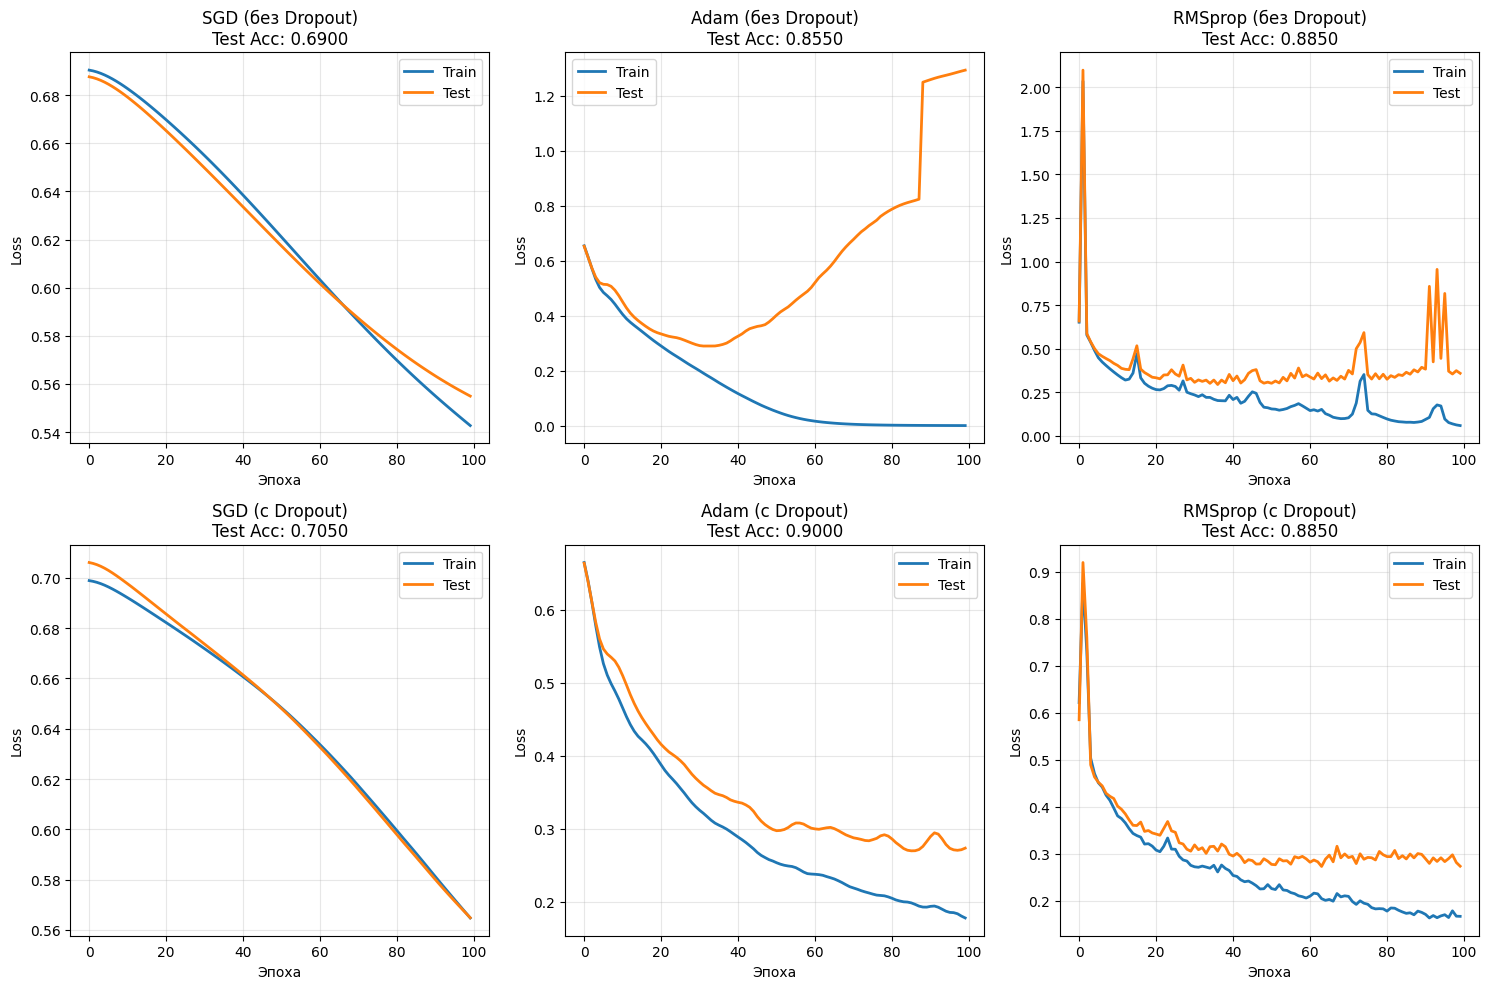

In [31]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Графики потерь без Dropout
for idx, opt in enumerate(optimizers):
    ax = axes[0, idx]
    result = results_no_dropout[opt]
    ax.plot(result['train_losses'], label='Train', linewidth=2)
    ax.plot(result['test_losses'], label='Test', linewidth=2)
    ax.set_title(f'{opt} (без Dropout)\nTest Acc: {result["final_test_acc"]:.4f}')
    ax.set_xlabel('Эпоха')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Графики потерь с Dropout
for idx, opt in enumerate(optimizers):
    ax = axes[1, idx]
    result = results_with_dropout[opt]
    ax.plot(result['train_losses'], label='Train', linewidth=2)
    ax.plot(result['test_losses'], label='Test', linewidth=2)
    ax.set_title(f'{opt} (с Dropout)\nTest Acc: {result["final_test_acc"]:.4f}')
    ax.set_xlabel('Эпоха')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Сводня таблица результатов

In [35]:
print("\n{:<10} {:<10} {:<12} {:<12} {:<12} {:<12}".format(
    "Оптимизатор", "Dropout", "Train Loss", "Test Loss", "Train Acc", "Test Acc"))
print("-" * 70)

for opt in optimizers:
    # Без Dropout
    res1 = results_no_dropout[opt]
    print("{:<10} {:<10} {:<12.4f} {:<12.4f} {:<12.4f} {:<12.4f}".format(
        opt, "Нет",
        res1['final_train_loss'], res1['final_test_loss'],
        res1['final_train_acc'], res1['final_test_acc']
    ))

    # С Dropout
    res2 = results_with_dropout[opt]
    print("{:<10} {:<10} {:<12.4f} {:<12.4f} {:<12.4f} {:<12.4f}".format(
        opt, "0.5",
        res2['final_train_loss'], res2['final_test_loss'],
        res2['final_train_acc'], res2['final_test_acc']
    ))
    print("-" * 70)




Оптимизатор Dropout    Train Loss   Test Loss    Train Acc    Test Acc    
----------------------------------------------------------------------
SGD        Нет        0.5427       0.5550       0.7250       0.6900      
SGD        0.5        0.5648       0.5648       0.7462       0.7050      
----------------------------------------------------------------------
Adam       Нет        0.0010       1.2923       1.0000       0.8550      
Adam       0.5        0.1781       0.2738       0.9312       0.9000      
----------------------------------------------------------------------
RMSprop    Нет        0.0596       0.3593       0.9837       0.8850      
RMSprop    0.5        0.1670       0.2737       0.9475       0.8850      
----------------------------------------------------------------------


Видно, что Adam с Dropout достигает наилучшей точности и успешно борется с переобучением, SGD значительно уступает по эффективности, а RMSprop показывает сравнимую с Adam производительность.

Работа с MNIST

Загрузка датасета MNIST

In [52]:
from torchvision import datasets, transforms

# Определение преобразований
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Загрузка данных
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Обучающих примеров: {len(train_dataset)}")
print(f"Тестовых примеров: {len(test_dataset)}")

Обучающих примеров: 60000
Тестовых примеров: 10000


Создаем модель для MNIST

In [36]:
class MNISTClassifier(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super(MNISTClassifier, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Преобразуем изображение в вектор
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

Функция для обучения MNIST

In [45]:
def train_and_evaluate_mnist(optimizer_name, learning_rate=0.001, epochs=5, dropout_rate=0.0):
    print(f"\n{'─'*50}")
    print(f"MNIST | Оптимизатор: {optimizer_name}, Dropout: {dropout_rate}")
    print(f"{'─'*50}")

    # Создание модели
    model = MNISTClassifier(dropout_rate=dropout_rate)

    # Выбор оптимизатора
    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    criterion = nn.CrossEntropyLoss()

    # Обучение
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        # Обучение
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = output.max(1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()

        # Оценка
        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                test_loss += criterion(output, target).item()
                _, predicted = output.max(1)
                total_test += target.size(0)
                correct_test += (predicted == target).sum().item()

        # Вычисляем метрики
        avg_train_loss = train_loss / len(train_loader)
        avg_test_loss = test_loss / len(test_loader)
        train_acc = correct_train / total_train
        test_acc = correct_test / total_test

        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        # Прогресс
        print(f"Эпоха {epoch+1:2d}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

    return {
        'model': model,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'final_train_acc': train_accuracies[-1],
        'final_test_acc': test_accuracies[-1],
        'final_train_loss': train_losses[-1],
        'final_test_loss': test_losses[-1]
    }

Эксперименты с MNIST


Без Dropout

In [48]:
optimizers = ["SGD", "Adam", "RMSprop"]
results_mnist_no_dropout = {}

for opt in optimizers:
    results_mnist_no_dropout[opt] = train_and_evaluate_mnist(
        optimizer_name=opt,
        learning_rate= 0.01,
        epochs=5,
        dropout_rate=0.0
    )


──────────────────────────────────────────────────
MNIST | Оптимизатор: SGD, Dropout: 0.0
──────────────────────────────────────────────────
Эпоха  1/5 | Train Loss: 0.4337 | Test Loss: 0.2033 | Train Acc: 0.8680 | Test Acc: 0.9367
Эпоха  2/5 | Train Loss: 0.1731 | Test Loss: 0.1292 | Train Acc: 0.9468 | Test Acc: 0.9604
Эпоха  3/5 | Train Loss: 0.1253 | Test Loss: 0.1182 | Train Acc: 0.9610 | Test Acc: 0.9634
Эпоха  4/5 | Train Loss: 0.1000 | Test Loss: 0.0996 | Train Acc: 0.9693 | Test Acc: 0.9700
Эпоха  5/5 | Train Loss: 0.0831 | Test Loss: 0.1153 | Train Acc: 0.9739 | Test Acc: 0.9645

──────────────────────────────────────────────────
MNIST | Оптимизатор: Adam, Dropout: 0.0
──────────────────────────────────────────────────
Эпоха  1/5 | Train Loss: 0.3860 | Test Loss: 0.2543 | Train Acc: 0.8804 | Test Acc: 0.9217
Эпоха  2/5 | Train Loss: 0.2510 | Test Loss: 0.2190 | Train Acc: 0.9268 | Test Acc: 0.9327
Эпоха  3/5 | Train Loss: 0.2328 | Test Loss: 0.2748 | Train Acc: 0.9335 | Test

C Dropout

In [49]:
optimizers = ["SGD", "Adam", "RMSprop"]
results_mnist_with_dropout = {}

for opt in optimizers:
    results_mnist_with_dropout[opt] = train_and_evaluate_mnist(
        optimizer_name=opt,
        learning_rate= 0.01,
        epochs=5,
        dropout_rate=0.5
    )


──────────────────────────────────────────────────
MNIST | Оптимизатор: SGD, Dropout: 0.5
──────────────────────────────────────────────────
Эпоха  1/5 | Train Loss: 0.8035 | Test Loss: 0.2853 | Train Acc: 0.7418 | Test Acc: 0.9165
Эпоха  2/5 | Train Loss: 0.4864 | Test Loss: 0.2224 | Train Acc: 0.8573 | Test Acc: 0.9328
Эпоха  3/5 | Train Loss: 0.4204 | Test Loss: 0.2102 | Train Acc: 0.8793 | Test Acc: 0.9345
Эпоха  4/5 | Train Loss: 0.3734 | Test Loss: 0.1862 | Train Acc: 0.8921 | Test Acc: 0.9424
Эпоха  5/5 | Train Loss: 0.3545 | Test Loss: 0.1774 | Train Acc: 0.8981 | Test Acc: 0.9457

──────────────────────────────────────────────────
MNIST | Оптимизатор: Adam, Dropout: 0.5
──────────────────────────────────────────────────
Эпоха  1/5 | Train Loss: 1.4151 | Test Loss: 0.7822 | Train Acc: 0.4983 | Test Acc: 0.7963
Эпоха  2/5 | Train Loss: 1.3412 | Test Loss: 0.7256 | Train Acc: 0.5350 | Test Acc: 0.8326
Эпоха  3/5 | Train Loss: 1.3370 | Test Loss: 0.7690 | Train Acc: 0.5376 | Test

Построим сводную таблицу результатов

In [50]:
print("\n" + "-" * 70)
print("СВОДНАЯ ТАБЛИЦА MNIST")
print("-" * 70)
print("{:<12} {:<10} {:<12} {:<12} {:<12} {:<12}".format(
    "Оптимизатор", "Dropout", "Train Loss", "Test Loss", "Train Acc", "Test Acc"))
print("-" * 70)

for opt in optimizers:
    # Без Dropout
    res1 = results_mnist_no_dropout[opt]
    print("{:<12} {:<10} {:<12.4f} {:<12.4f} {:<12.4f} {:<12.4f}".format(
        opt, "Нет",
        res1['final_train_loss'], res1['final_test_loss'],
        res1['final_train_acc'], res1['final_test_acc']
    ))

    # С Dropout
    res2 = results_mnist_with_dropout[opt]
    print("{:<12} {:<10} {:<12.4f} {:<12.4f} {:<12.4f} {:<12.4f}".format(
        opt, "0.5",
        res2['final_train_loss'], res2['final_test_loss'],
        res2['final_train_acc'], res2['final_test_acc']
    ))
    print("-" * 70)


----------------------------------------------------------------------
СВОДНАЯ ТАБЛИЦА MNIST
----------------------------------------------------------------------
Оптимизатор  Dropout    Train Loss   Test Loss    Train Acc    Test Acc    
----------------------------------------------------------------------
SGD          Нет        0.0831       0.1153       0.9739       0.9645      
SGD          0.5        0.3545       0.1774       0.8981       0.9457      
----------------------------------------------------------------------
Adam         Нет        0.2127       0.2383       0.9412       0.9340      
Adam         0.5        1.3654       0.6920       0.5212       0.8429      
----------------------------------------------------------------------
RMSprop      Нет        0.2637       0.1928       0.9276       0.9487      
RMSprop      0.5        1.2939       0.8026       0.5781       0.7404      
----------------------------------------------------------------------


Видно, что на датасете MNIST модель без Dropout показывает хорошую точность, в то время как Dropout снижает итоговый результат, демонстрируя разный эффект регуляризации на различных типах данных.

#Заключение

Проделанная лабораторная работа показывает, что нейронная сеть успешно решает задачу бинарной классификации синтетических данных. Модель достигает высокой точности на тестовой выборке с использованием Adam и Dropout, демонстрируя способность находить сложные нелинейные зависимости. Adam показывает лучшие результаты на синтетических данных, но требует регуляризации для предотвращения переобучения. Для MNIST лучшим оказался SGD без регуляризации.